In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


### Data Loading and Preprocessing

In [5]:
import os
import cv2

data_dir = r"UCMerced_LandUse"
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
image_size = (256, 256)
num_classes = len(classes)

images = []
labels = []

for idx, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    image_files = sorted(os.listdir(class_dir))
    
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        img = cv2.imread(image_path)
        if img is not None:  # تأكد أن الصورة تم تحميلها بنجاح
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(idx)


In [6]:
classes

['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']

In [7]:
images = np.array(images)
labels = np.array(labels)

In [8]:
labels

array([ 0,  0,  0, ..., 20, 20, 20], shape=(2100,))

### Dataset Splitting: with ensurance that the split mainains a balance of images from different categories

In [9]:
import numpy as np

def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    indices = np.arange(len(X))
    np.random.shuffle(indices)
    

    test_size = int(len(X) * test_size)
    train_size = len(X) - test_size
    
    X_train = X[indices[:train_size]]
    X_test = X[indices[train_size:]]
    y_train = y[indices[:train_size]]
    y_test = y[indices[train_size:]]
    
    return X_train, X_test, y_train, y_test


In [10]:

X_train, X_test = [], []
y_train, y_test = [], []
for class_idx in range(num_classes):
    class_images = images[labels == class_idx]
    class_labels = labels[labels == class_idx]
    
    X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
        class_images, class_labels, test_size=0.2, random_state=42
    )
    
    X_train.extend(X_train_cls)
    y_train.extend(y_train_cls)
    X_test.extend(X_test_cls)
    y_test.extend(y_test_cls)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set: X={X_test.shape}, y={y_test.shape}")



Training set: X=(1680, 256, 256, 3), y=(1680,)
Testing set: X=(420, 256, 256, 3), y=(420,)


#### For each class, we use train_test_split to ensure the train-test split maintains class balance.


### SIFT Feature Extraction : For each image in the dataset:
– Detect and compute SIFT key points and descriptors,
– Store the descriptors along with their corresponding class labels.

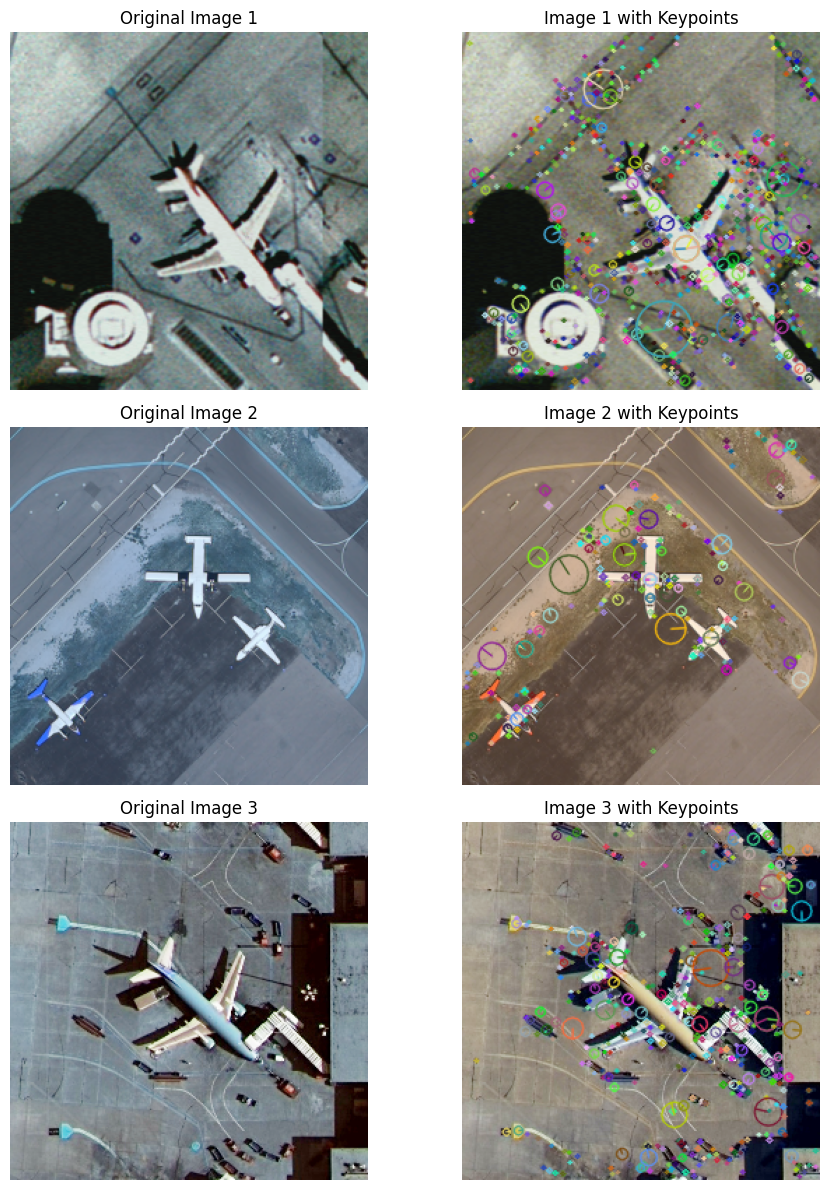

In [13]:
def visualize_keypoints(image, keypoints):
    img_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img_rgb = cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB)
    return img_rgb
sift = cv2.SIFT_create()
num_images = 3  

fig, axes = plt.subplots(num_images, 2, figsize=(10, 4 * num_images)) 
axes = axes.ravel()  

for i in range(num_images):
    img = X_train[i + 100] 
    
    axes[2*i].imshow(img)  
    axes[2*i].axis('off')  
    axes[2*i].set_title(f"Original Image {i + 1}")

    keypoints, descriptors = sift.detectAndCompute(img, None)
    img_with_keypoints = visualize_keypoints(img, keypoints) 
    
    axes[2*i + 1].imshow(img_with_keypoints)  
    axes[2*i + 1].axis('off')  
    axes[2*i + 1].set_title(f"Image {i + 1} with Keypoints")

plt.tight_layout()
plt.show()

### Building a Visual Vocabulary:
– Cluster the extracted features from all training images into a set of visual words
using a clustering algorithm such as K-means. Each cluster center becomes a
visual word

#### I found that there are 5 images with no descriptors, So i created a default  histogram (all zeros) for missing descriptors

In [14]:
def descriptors(X_train):
    train_descriptors = []

    for img in X_train:

                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                sift = cv2.SIFT_create()
                keypoints, descriptors = sift.detectAndCompute(img, None)
                
                if descriptors is not None:
                    train_descriptors.append(descriptors) 
    descriptors = np.vstack(train_descriptors)
    return descriptors

In [15]:
def img_hist(x, kmeans,num_clusters):
        image_histograms = []

        for img in x:
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            sift = cv2.SIFT_create()
            keypoints, descriptors = sift.detectAndCompute(gray_img, None)
            
            if descriptors is not None:
                labels = kmeans.predict(descriptors)
                
                histogram, _ = np.histogram(labels, bins=np.arange(num_clusters + 1))
                image_histograms.append(histogram)
            else:
                image_histograms.append(np.zeros(num_clusters))
        

        image_histograms = np.array(image_histograms)
        image_histograms_norm = normalize(image_histograms, norm='l2')
        return image_histograms_norm


In [16]:
descriptors__=descriptors(X_train)

In [17]:
def bovw(X_train,X_test,num_clusters,y_test,descriptors):
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(descriptors)
        visual_vocabulary = kmeans.cluster_centers_

        print(f"Visual Vocabulary: {visual_vocabulary.shape[0]} visual words created.")    
        svm = SVC(kernel='linear', random_state=42)
        svm.fit(img_hist(X_train,kmeans=kmeans,num_clusters=num_clusters), y_train)
        y_pred = svm.predict(img_hist(X_test,kmeans,num_clusters))
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy * 100:.2f}%")

        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm, display_labels=range(21)).plot(cmap='Greens')
        plt.title("Confusion Matrix")
        plt.show()

Visual Vocabulary: 50 visual words created.
Accuracy: 61.67%


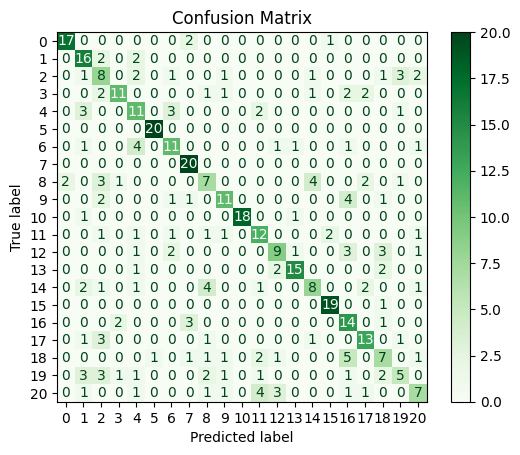

In [18]:
bovw(X_train,X_test,num_clusters=50,y_test=y_test,descriptors=descriptors__)

### Trying with 100 clusters

Visual Vocabulary: 100 visual words created.
Accuracy: 65.24%


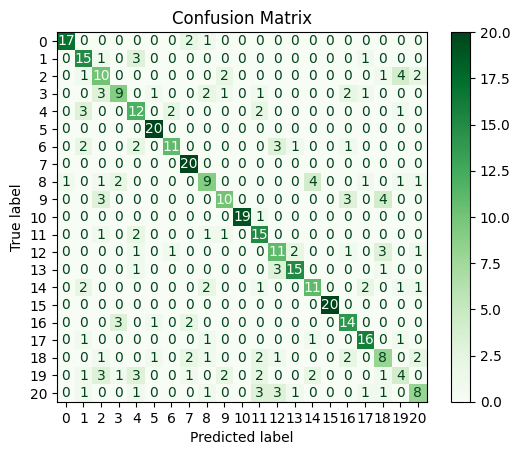

In [19]:
bovw(X_train,X_test,num_clusters=100,y_test=y_test,descriptors=descriptors__)

## Trying with 500 clusters

Visual Vocabulary: 500 visual words created.
Accuracy: 72.62%


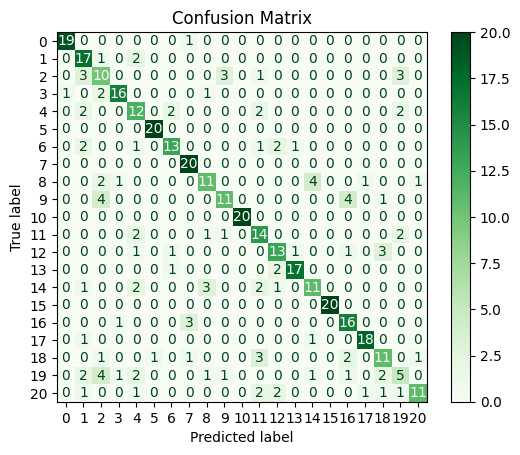

In [20]:
bovw(X_train,X_test,num_clusters=500,y_test=y_test,descriptors=descriptors__)

Accuracy when doing 50 clusters: 61.67%

Accuracy when doing 100 clusters: 65.24%

Accuracy when doing 500 clusters: Accuracy: 72.62%
